<a href="https://colab.research.google.com/github/Jungkihong07/Deepwave/blob/main/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: C:\Users\rosac\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [ ]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: C:\Users\rosac\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


## 학습용 데이터 로딩

In [ ]:
train_audio_path = 'train'
train_label_path = 'train_label.txt'

In [ ]:
import librosa
import matplotlib
import numpy as np
import sklearn
import tensorflow as tf
import ipykernel
print("librosa version:", librosa.__version__)
print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("tensorflow version:", tf.__version__)


librosa version: 0.11.0
matplotlib version: 3.9.4
numpy version: 2.0.2
scikit-learn version: 1.6.1
tensorflow version: 2.19.0


### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [ ]:
max_len = 4000
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

Loading MFCC: 100%|████████████████████████████████████████████████████████████████| 4000/4000 [01:57<00:00, 34.00it/s]


In [ ]:
test_audio_path = 'test'
test_label_path = 'test_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.
- 캐시를 생성하고 싶다면 목차의 "데이터 셋 캐시 저장"을 실행하시기 바립니다.

In [ ]:
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)

ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

Loading MFCC: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.73it/s]


### 데이터 셋 캐시 저장
- 사용 예시
save_mfcc_cache(X, y, scaler, cache_prefix="train")
- 사용 조건
  - 목차의 "캐시가 없을 때"를 실행하고 난 후 실행하셔야 합니다.

#### Train set 캐시 저장 함수
- test set을 위한 코드가 아닙니다. train set에만 사용하시기 바랍니다.

In [ ]:
# ──────────── 예시 셀 A ──────────── #
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

def save_mfcc_cache_train(X, y, scaler, directory="cache/train"):
    os.makedirs(directory, exist_ok=True)
    X_path      = os.path.join(directory, "X.npy")
    y_path      = os.path.join(directory, "y.npy")
    scaler_path = os.path.join(directory, "scaler.npy")

    np.save(X_path, X)
    np.save(y_path, y)
    np.save(scaler_path, {'mean': scaler.mean_, 'scale': scaler.scale_})
    print("✅ 학습용 캐시 저장 완료:")
    print(f"   - X      → {X_path}")
    print(f"   - y      → {y_path}")
    print(f"   - scaler → {scaler_path}")
# 이 셀을 실행하면 “함수만 정의”되고 출력(프린트)은 없음.
# ──────────── 셀 A 끝 ──────────── #

# ──────────── 예시 셀 B ──────────── #
# 위에서 이미 정의한 save_mfcc_cache_train 함수를 "실제로 호출"하는 부분
save_mfcc_cache_train(X, y, scaler, directory="cache/train")


✅ 학습용 캐시 저장 완료:
   - X      → cache/train\X.npy
   - y      → cache/train\y.npy
   - scaler → cache/train\scaler.npy


#### Test set 캐시 저장
-  test set을 위한 코드입니다.

In [ ]:
os.makedirs("cache/test", exist_ok=True)
test_X_path = "cache/test/X.npy"
test_y_path = "cache/test/y.npy"

np.save(test_X_path, X_test)
np.save(test_y_path, y_test)
print("✅ 테스트셋 캐시 저장 완료")


✅ 테스트셋 캐시 저장 완료


### 캐시로부터 MFCC 데이터 로드 함수
- 사용 예시
X, y, scaler = load_mfcc_cache(cache_prefix="train")
- 사용 조건
  - 이후 캐시를 저장하고 난 후는 계속해서 MFCC 데이터 로드 함수를 활용해 이후, 로드할 필요 없이 사용하시면 됩니다.

#### Train set 캐시 로드 함수

In [ ]:
def load_mfcc_cache_train(directory="cache/train"):
    """
    설명:
      - "cache/train/" 폴더 아래에 저장된 X.npy, y.npy, scaler.npy 세 파일을 불러와,
        표준화된 학습용 데이터 X, 레이블 y, 그리고 복원된 StandardScaler 객체를 반환합니다.
      - 파일이 없으면 FileNotFoundError을 발생시킵니다.

    매개변수:
      directory : str, 캐시가 저장된 학습용 디렉터리 경로 (예: "cache/train")

    반환값:
      X      : np.ndarray, 학습용 입력 데이터
      y      : np.ndarray, 학습용 레이블
      scaler : sklearn.preprocessing.StandardScaler, 복원된 표준화 객체
    """
    # 1. 파일 경로 구성
    X_path      = os.path.join(directory, "X.npy")
    y_path      = os.path.join(directory, "y.npy")
    scaler_path = os.path.join(directory, "scaler.npy")

    # 2. 파일 존재 여부 검사
    if not (os.path.exists(X_path) and os.path.exists(y_path) and os.path.exists(scaler_path)):
        raise FileNotFoundError(f"❌ 학습용 캐시 파일이 존재하지 않습니다: {directory}")

    # 3. .npy 파일에서 데이터 로드
    X = np.load(X_path)
    y = np.load(y_path)
    scaler_params = np.load(scaler_path, allow_pickle=True).item()

    # 4. StandardScaler 객체로 복원
    scaler = StandardScaler()
    scaler.mean_  = scaler_params['mean']
    scaler.scale_ = scaler_params['scale']

    print(f"✅ 학습용 캐시 불러오기 완료: {directory}")
    return X, y, scaler


#### test set 캐시 로드

In [ ]:
def load_mfcc_cache_test(directory="cache/test"):
    """
    설명:
      - "cache/test/" 폴더 아래에 저장된 X.npy, y.npy 두 파일을 불러와
        테스트용 입력 X_test와 레이블 y_test를 반환합니다.
      - 파일이 없으면 FileNotFoundError을 발생시킵니다.

    매개변수:
      directory : str, 캐시가 저장된 테스트용 디렉터리 경로 (예: "cache/test")

    반환값:
      X_test : np.ndarray, 테스트용 입력 데이터
      y_test : np.ndarray, 테스트용 레이블
    """
    # 1. 파일 경로 구성
    X_path = os.path.join(directory, "X.npy")
    y_path = os.path.join(directory, "y.npy")

    # 2. 파일 존재 여부 검사
    if not (os.path.exists(X_path) and os.path.exists(y_path)):
        raise FileNotFoundError(f"❌ 테스트용 캐시 파일이 존재하지 않습니다: {directory}")

    # 3. .npy 파일에서 데이터 로드
    X_test = np.load(X_path)
    y_test = np.load(y_path)

    print(f"✅ 테스트용 캐시 불러오기 완료: {directory}")
    return X_test, y_test




## 1. 필요 라이브러러 임포트 및 다운로드

In [ ]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------
import os
import random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy

# 재현성 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## 데이터 로딩 함수 정의

In [ ]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=200):
    entries = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                entries.append((parts[1], parts[-1]))
    df = pd.DataFrame(entries, columns=['filename','label'])

    X_list, y_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading MFCC"):
        fp = os.path.join(audio_path, row['filename'])
        if not os.path.isfile(fp):
            continue
        try:
            audio, sr = librosa.load(fp, sr=16000)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T # 기존에는 13이었음.
            if mfcc.shape[0] < max_len:
                mfcc = np.pad(mfcc, ((0, max_len-mfcc.shape[0]), (0,0)), mode='constant')
            else:
                mfcc = mfcc[:max_len]
            X_list.append(mfcc)
            y_list.append(0 if row['label']=='Real' else 1)
        except:
            continue

    return np.array(X_list), np.array(y_list)


def standardize(X):
    ns, nt, nf = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler


## DNN 모델 정의

In [ ]:
def build_dnn_model(
    input_shape,
    units1=128,         # 첫 번째 Dense 레이어의 유닛 수 (튜닝 대상)
    units2=64,          # 두 번째 Dense 레이어의 유닛 수 (튜닝 대상)
    dropout1=0.3,       # 첫 번째 Dropout 비율 (튜닝 대상)
    dropout2=0.3,       # 두 번째 Dropout 비율 (튜닝 대상)
    learning_rate=1e-3  # Adam 학습률 (튜닝 대상)
):
    """
    기존 모델 정의 부분을 하이퍼파라미터 인자를 받도록 수정한 함수입니다.
      - units1, units2: 각 Dense 레이어의 유닛 개수
      - dropout1, dropout2: 각 Dropout 레이어 비율
      - learning_rate: Adam 옵티마이저 학습률
    """
    model = models.Sequential([
        layers.Input(shape=input_shape, name="input_mfcc"),
        layers.Flatten(name="flatten"),

        # 첫 번째 Dense 블록
        layers.Dense(units1, activation=None, name="dense_1"),
        layers.BatchNormalization(name="bn_1"),
        layers.Activation('relu', name="act_1"),
        layers.Dropout(dropout1, name="dropout_1"),

        # 두 번째 Dense 블록
        layers.Dense(units2, activation=None, name="dense_2"),
        layers.BatchNormalization(name="bn_2"),
        layers.Activation('relu', name="act_2"),
        layers.Dropout(dropout2, name="dropout_2"),

        # 출력층
        layers.Dense(1, activation='sigmoid', name="output")
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


[I 2025-06-04 11:10:32,682] A new study created in memory with name: no-name-3a4267a9-fe93-4312-99ca-1de6b6a208d7
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8270 - loss: 0.3980 - val_accuracy: 0.9425 - val_loss: 0.1598 - learning_rate: 5.2916e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9814 - loss: 0.1029 - val_accuracy: 0.9775 - val_loss: 0.0733 - learning_rate: 5.2916e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9933 - loss: 0.0578 - val_accuracy: 0.9875 - val_loss: 0.0499 - learning_rate: 5.2916e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9989 - loss: 0.0374 - val_accuracy: 0.9887 - val_loss: 0.0422 - learning_rate: 5.2916e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9998 - loss: 0.0289 - val_accuracy: 0.9912 - val_loss: 0.0393 - learning_rate: 5.2916e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 0.9937 - val_loss: 0.0354 - learning_rate: 5.2916e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000

Best trial: 0. Best value: 0.99375:   3%|█▌                                             | 1/30 [01:17<37:19, 77.23s/it]

[Trial  0] units1=128, units2=64, dropout1=0.2, dropout2=0.5, lr=5.3e-04, batch_size=128 → val_acc=0.9937

[I 2025-06-04 11:11:49,913] Trial 0 finished with value: 0.9937499761581421 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.0005291638976855859, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8665 - loss: 0.3338 - val_accuracy: 0.9812 - val_loss: 0.0651 - learning_rate: 9.5620e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9891 - loss: 0.0722 - val_accuracy: 0.9925 - val_loss: 0.0395 - learning_rate: 9.5620e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9889 - loss: 0.0418 - val_accuracy: 0.9900 - val_loss: 0.0310 - learning_rate: 9.5620e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9973 - loss: 0.0220 - val_accuracy: 0.9912 - val_loss: 0.0275 - learning_rate: 9.5620e-04
E

Best trial: 0. Best value: 0.99375:   7%|███▏                                           | 2/30 [02:03<27:36, 59.17s/it]

[Trial  1] units1=64, units2=64, dropout1=0.5, dropout2=0.2, lr=9.6e-04, batch_size=32 → val_acc=0.9925

[I 2025-06-04 11:12:36,432] Trial 1 finished with value: 0.9925000071525574 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.0009562008106773795, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.8504 - loss: 0.3300 - val_accuracy: 0.9762 - val_loss: 0.0705 - learning_rate: 2.4373e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9870 - loss: 0.0576 - val_accuracy: 0.9925 - val_loss: 0.0411 - learning_rate: 2.4373e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9956 - loss: 0.0329 - val_accuracy: 0.9912 - val_loss: 0.0385 - learning_rate: 2.4373e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9985 - loss: 0.0192 - val_accuracy: 0.9925 - val_loss: 0.0331 - learning_rate: 2.4373e-

Best trial: 0. Best value: 0.99375:  10%|████▌                                         | 3/30 [05:04<51:35, 114.65s/it]

[Trial  2] units1=384, units2=128, dropout1=0.4, dropout2=0.5, lr=2.4e-04, batch_size=32 → val_acc=0.9925

[I 2025-06-04 11:15:37,097] Trial 2 finished with value: 0.9925000071525574 and parameters: {'units1': 384, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.0002437266437497274, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9012 - loss: 0.2453 - val_accuracy: 0.9812 - val_loss: 0.0835 - learning_rate: 0.0052
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.9851 - loss: 0.0463 - val_accuracy: 0.9850 - val_loss: 0.0506 - learning_rate: 0.0052
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9925 - loss: 0.0239 - val_accuracy: 0.9862 - val_loss: 0.0485 - learning_rate: 0.0052
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9925 - loss: 0.0212 - val_accuracy: 0.9925 - val_loss: 0.0501 - learning_rate: 0.0052
Epoch 5/50
20

Best trial: 0. Best value: 0.99375:  13%|██████▏                                       | 4/30 [07:58<59:47, 137.97s/it]


[I 2025-06-04 11:18:30,836] Trial 3 finished with value: 0.9912499785423279 and parameters: {'units1': 192, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'learning_rate': 0.005162305305782334, 'batch_size': 16}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.9065 - loss: 0.2379 - val_accuracy: 0.9812 - val_loss: 0.0805 - learning_rate: 0.0077
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.9851 - loss: 0.0367 - val_accuracy: 0.9887 - val_loss: 0.0429 - learning_rate: 0.0077
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9961 - loss: 0.0127 - val_accuracy: 0.9925 - val_loss: 0.0306 - learning_rate: 0.0077
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.9941 - loss: 0.0140 - val_accuracy: 0.9875 - val_loss: 0.0441 - learning_rate: 0.0077
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9944 - loss: 0.0186 - val_accuracy: 0.9887 - va

Best trial: 0. Best value: 0.99375:  17%|███████▎                                    | 5/30 [11:04<1:04:44, 155.36s/it]


[I 2025-06-04 11:21:37,033] Trial 4 finished with value: 0.9912499785423279 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.007711788571894636, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.8607 - loss: 0.3290 - val_accuracy: 0.9775 - val_loss: 0.0731 - learning_rate: 1.4293e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.9909 - loss: 0.0674 - val_accuracy: 0.9937 - val_loss: 0.0430 - learning_rate: 1.4293e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9989 - loss: 0.0400 - val_accuracy: 0.9925 - val_loss: 0.0401 - learning_rate: 1.4293e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9986 - loss: 0.0292 - val_accuracy: 0.9937 - val_loss: 0.0347 - learning_rate: 1.4293e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.9994 - loss: 0.0

Best trial: 0. Best value: 0.99375:  20%|████████▊                                   | 6/30 [17:24<1:32:46, 231.93s/it]


[I 2025-06-04 11:27:57,578] Trial 5 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00014292928613626935, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7643 - loss: 0.4867 - val_accuracy: 0.9413 - val_loss: 0.1770 - learning_rate: 1.5269e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9816 - loss: 0.1560 - val_accuracy: 0.9775 - val_loss: 0.1117 - learning_rate: 1.5269e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9913 - loss: 0.1182 - val_accuracy: 0.9875 - val_loss: 0.0922 - learning_rate: 1.5269e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9958 - loss: 0.0952 - val_accuracy: 0.9887 - val_loss: 0.0848 - learning_rate: 1.5269e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9978 - loss: 0.0831 - val_accuracy

Best trial: 0. Best value: 0.99375:  23%|██████████▎                                 | 7/30 [19:14<1:13:33, 191.91s/it]

[I 2025-06-04 11:29:47,106] Trial 6 finished with value: 0.9925000071525574 and parameters: {'units1': 96, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0001526852461589429, 'batch_size': 64}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7803 - loss: 0.4609 - val_accuracy: 0.9525 - val_loss: 0.1145 - learning_rate: 1.1669e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9921 - loss: 0.1020 - val_accuracy: 0.9862 - val_loss: 0.0598 - learning_rate: 1.1669e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9958 - loss: 0.0641 - val_accuracy: 0.9900 - val_loss: 0.0492 - learning_rate: 1.1669e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9987 - loss: 0.0470 - val_accuracy: 0.9925 - val_loss: 0.0427 - learning_rate: 1.1669e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9995 - loss: 0.0375 - val_accura

Best trial: 0. Best value: 0.99375:  27%|███████████▋                                | 8/30 [22:08<1:08:16, 186.22s/it]

[I 2025-06-04 11:32:41,146] Trial 7 finished with value: 0.9937499761581421 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'learning_rate': 0.00011669446016593203, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.8315 - loss: 0.3635 - val_accuracy: 0.9675 - val_loss: 0.0924 - learning_rate: 2.9301e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9908 - loss: 0.0522 - val_accuracy: 0.9887 - val_loss: 0.0491 - learning_rate: 2.9301e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9982 - loss: 0.0257 - val_accuracy: 0.9912 - val_loss: 0.0383 - learning_rate: 2.9301e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9974 - loss: 0.0220 - val_accuracy: 0.9912 - val_loss: 0.0346 - learning_rate: 2.9301e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9981 - loss: 0.0150 - val_ac

Best trial: 0. Best value: 0.99375:  30%|█████████████▏                              | 9/30 [25:04<1:04:01, 182.94s/it]


[I 2025-06-04 11:35:36,856] Trial 8 finished with value: 0.9937499761581421 and parameters: {'units1': 384, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.4, 'learning_rate': 0.00029301153767192416, 'batch_size': 64}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.9062 - loss: 0.2729 - val_accuracy: 0.9850 - val_loss: 0.0509 - learning_rate: 0.0014
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9854 - loss: 0.0638 - val_accuracy: 0.9912 - val_loss: 0.0375 - learning_rate: 0.0014
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9963 - loss: 0.0242 - val_accuracy: 0.9912 - val_loss: 0.0347 - learning_rate: 0.0014
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.9963 - loss: 0.0189 - val_accuracy: 0.9912 - val_loss: 0.0315 - learning_rate: 0.0014
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.9964 - loss: 0.0128 - val_accuracy: 0.9862 - 

Best trial: 0. Best value: 0.99375:  33%|██████████████▎                            | 10/30 [34:15<1:38:51, 296.59s/it]

[Trial  9] units1=512, units2=32, dropout1=0.1, dropout2=0.4, lr=1.4e-03, batch_size=16 → val_acc=0.9937

[I 2025-06-04 11:44:47,928] Trial 9 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.001365447404836599, 'batch_size': 16}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8461 - loss: 0.3510 - val_accuracy: 0.9600 - val_loss: 0.1166 - learning_rate: 7.3714e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9940 - loss: 0.0309 - val_accuracy: 0.9862 - val_loss: 0.0600 - learning_rate: 7.3714e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9986 - loss: 0.0117 - val_accuracy: 0.9900 - val_loss: 0.0459 - learning_rate: 7.3714e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9887 - val_loss: 0.0436 - learning_rate: 7.3714e-04
Epoch 5/50
2

Best trial: 0. Best value: 0.99375:  37%|███████████████▊                           | 11/30 [34:52<1:08:46, 217.18s/it]

[I 2025-06-04 11:45:25,065] Trial 10 finished with value: 0.9912499785423279 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.0007371429198732381, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7936 - loss: 0.4338 - val_accuracy: 0.9475 - val_loss: 0.1431 - learning_rate: 4.2448e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9893 - loss: 0.1173 - val_accuracy: 0.9737 - val_loss: 0.0817 - learning_rate: 4.2448e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9947 - loss: 0.0666 - val_accuracy: 0.9875 - val_loss: 0.0523 - learning_rate: 4.2448e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9970 - loss: 0.0484 - val_accuracy: 0.9912 - val_loss: 0.0409 - learning_rate: 4.2448e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9988 - loss: 0.0346 - val_accuracy: 0.9912 - val_

Best trial: 0. Best value: 0.99375:  40%|██████████████████                           | 12/30 [35:52<50:51, 169.55s/it]

[Trial 11] units1=128, units2=64, dropout1=0.4, dropout2=0.3, lr=4.2e-04, batch_size=128 → val_acc=0.9937

[I 2025-06-04 11:46:25,656] Trial 11 finished with value: 0.9937499761581421 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0004244840114428352, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8790 - loss: 0.2864 - val_accuracy: 0.9750 - val_loss: 0.0819 - learning_rate: 0.0019
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9905 - loss: 0.0467 - val_accuracy: 0.9887 - val_loss: 0.0421 - learning_rate: 0.0019
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9967 - loss: 0.0210 - val_accuracy: 0.9900 - val_loss: 0.0319 - learning_rate: 0.0019
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9991 - loss: 0.0085 - val_accuracy: 0.9900 - val_loss: 0.0317 - learning_rate: 0.0019


Best trial: 0. Best value: 0.99375:  43%|███████████████████▌                         | 13/30 [37:06<39:46, 140.39s/it]

[I 2025-06-04 11:47:38,947] Trial 12 finished with value: 0.9900000095367432 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.0018981324482034887, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.8674 - loss: 0.2964 - val_accuracy: 0.9388 - val_loss: 0.2525 - learning_rate: 4.9075e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.9970 - loss: 0.0504 - val_accuracy: 0.9825 - val_loss: 0.0834 - learning_rate: 4.9075e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.9992 - loss: 0.0282 - val_accuracy: 0.9875 - val_loss: 0.0558 - learning_rate: 4.9075e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.9997 - loss: 0.0193 - val_accuracy: 0.9912 - val_loss: 0.0427 - learning_rate: 4.9075e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.9925 - 

Best trial: 0. Best value: 0.99375:  47%|█████████████████████                        | 14/30 [40:44<43:40, 163.79s/it]

[I 2025-06-04 11:51:16,820] Trial 13 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 0.0004907470925465368, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9022 - loss: 0.2498 - val_accuracy: 0.9825 - val_loss: 0.0654 - learning_rate: 0.0026
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9897 - loss: 0.0414 - val_accuracy: 0.9912 - val_loss: 0.0359 - learning_rate: 0.0026
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9977 - loss: 0.0121 - val_accuracy: 0.9912 - val_loss: 0.0372 - learning_rate: 0.0026
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9974 - loss: 0.0102 - val_accuracy: 0.9912 - val_loss: 0.0379 - learning_rate: 0.0026
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9912 - val_loss: 0

Best trial: 0. Best value: 0.99375:  50%|██████████████████████▌                      | 15/30 [41:33<32:20, 129.39s/it]

[I 2025-06-04 11:52:06,475] Trial 14 finished with value: 0.9900000095367432 and parameters: {'units1': 96, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.0026126191108000385, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.7853 - loss: 0.4528 - val_accuracy: 0.9312 - val_loss: 0.1496 - learning_rate: 1.9023e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9881 - loss: 0.1141 - val_accuracy: 0.9762 - val_loss: 0.0700 - learning_rate: 1.9023e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9977 - loss: 0.0688 - val_accuracy: 0.9900 - val_loss: 0.0515 - learning_rate: 1.9023e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9983 - loss: 0.0538 - val_accuracy: 0.9925 - val_loss: 0.0449 - learning_rate: 1.9023e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9986 - loss: 0.0435 - val_accur

Best trial: 0. Best value: 0.99375:  53%|████████████████████████                     | 16/30 [43:58<31:16, 134.07s/it]


[I 2025-06-04 11:54:31,418] Trial 15 finished with value: 0.9937499761581421 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.0001902293320764631, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8235 - loss: 0.3814 - val_accuracy: 0.9862 - val_loss: 0.0690 - learning_rate: 1.1111e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9800 - loss: 0.1019 - val_accuracy: 0.9900 - val_loss: 0.0466 - learning_rate: 1.1111e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9923 - loss: 0.0588 - val_accuracy: 0.9925 - val_loss: 0.0393 - learning_rate: 1.1111e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9973 - loss: 0.0383 - val_accuracy: 0.9912 - val_loss: 0.0370 - learning_rate: 1.1111e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9988 - loss: 0.0282 - val_accuracy

Best trial: 0. Best value: 0.99375:  57%|█████████████████████████▌                   | 17/30 [47:40<34:47, 160.55s/it]

[I 2025-06-04 11:58:13,539] Trial 16 finished with value: 0.9925000071525574 and parameters: {'units1': 192, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011110899088358946, 'batch_size': 16}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8492 - loss: 0.3520 - val_accuracy: 0.9725 - val_loss: 0.0885 - learning_rate: 5.8177e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9909 - loss: 0.0368 - val_accuracy: 0.9837 - val_loss: 0.0556 - learning_rate: 5.8177e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9987 - loss: 0.0133 - val_accuracy: 0.9912 - val_loss: 0.0377 - learning_rate: 5.8177e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9937 - val_loss: 0.0330 - learning_rate: 5.8177e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accurac

Best trial: 0. Best value: 0.99375:  60%|███████████████████████████                  | 18/30 [48:19<24:48, 124.04s/it]

[I 2025-06-04 11:58:52,585] Trial 17 finished with value: 0.9937499761581421 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.000581765657511884, 'batch_size': 64}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7334 - loss: 0.5431 - val_accuracy: 0.9638 - val_loss: 0.0917 - learning_rate: 3.3444e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9748 - loss: 0.1877 - val_accuracy: 0.9800 - val_loss: 0.0563 - learning_rate: 3.3444e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9901 - loss: 0.1287 - val_accuracy: 0.9900 - val_loss: 0.0428 - learning_rate: 3.3444e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9942 - loss: 0.0977 - val_accuracy: 0.9912 - val_loss: 0.0416 - learning_rate: 3.3444e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9964 - loss: 0.0847 - val_accuracy: 0.9925 - val_los

Best trial: 0. Best value: 0.99375:  63%|█████████████████████████████▏                | 19/30 [48:51<17:39, 96.29s/it]

[I 2025-06-04 11:59:24,225] Trial 18 finished with value: 0.9925000071525574 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.00033443547442935074, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.8872 - loss: 0.2667 - val_accuracy: 0.9800 - val_loss: 0.0737 - learning_rate: 0.0030
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9919 - loss: 0.0333 - val_accuracy: 0.9925 - val_loss: 0.0338 - learning_rate: 0.0030
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9982 - loss: 0.0124 - val_accuracy: 0.9900 - val_loss: 0.0324 - learning_rate: 0.0030
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9996 - loss: 0.0067 - val_accuracy: 0.9912 - val_loss: 0.0336 - learning_rate: 0.0030
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9979 - loss: 0.0050 - val_accuracy: 0.9875 - 

Best trial: 0. Best value: 0.99375:  67%|██████████████████████████████               | 20/30 [52:03<20:49, 124.94s/it]

[Trial 19] units1=512, units2=64, dropout1=0.3, dropout2=0.4, lr=3.0e-03, batch_size=32 → val_acc=0.9925

[I 2025-06-04 12:02:35,960] Trial 19 finished with value: 0.9925000071525574 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.0029986108375176686, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.8967 - loss: 0.2645 - val_accuracy: 0.9837 - val_loss: 0.0583 - learning_rate: 2.0886e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9916 - loss: 0.0541 - val_accuracy: 0.9912 - val_loss: 0.0387 - learning_rate: 2.0886e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9982 - loss: 0.0301 - val_accuracy: 0.9925 - val_loss: 0.0339 - learning_rate: 2.0886e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9991 - loss: 0.0202 - val_accuracy: 0.9925 - val_loss: 0.0308 - lear

Best trial: 0. Best value: 0.99375:  70%|███████████████████████████████▍             | 21/30 [57:37<28:10, 187.80s/it]

[Trial 20] units1=512, units2=64, dropout1=0.4, dropout2=0.3, lr=2.1e-04, batch_size=32 → val_acc=0.9925

[I 2025-06-04 12:08:10,310] Trial 20 finished with value: 0.9925000071525574 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0002088578446041724, 'batch_size': 32}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.7531 - loss: 0.5060 - val_accuracy: 0.9287 - val_loss: 0.1879 - learning_rate: 1.0049e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9916 - loss: 0.1325 - val_accuracy: 0.9700 - val_loss: 0.0955 - learning_rate: 1.0049e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9977 - loss: 0.0918 - val_accuracy: 0.9850 - val_loss: 0.0745 - learning_rate: 1.0049e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9984 - loss: 0.0707 - val_accuracy: 0.9900 - val_loss: 0.0640 - learning_rate: 1

Best trial: 0. Best value: 0.99375:  73%|███████████████████████████████▌           | 22/30 [1:00:32<24:31, 184.00s/it]

[I 2025-06-04 12:11:05,446] Trial 21 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'learning_rate': 0.00010048741754516857, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.7929 - loss: 0.4298 - val_accuracy: 0.8888 - val_loss: 0.2490 - learning_rate: 1.4142e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9950 - loss: 0.0779 - val_accuracy: 0.9700 - val_loss: 0.1009 - learning_rate: 1.4142e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9989 - loss: 0.0485 - val_accuracy: 0.9812 - val_loss: 0.0686 - learning_rate: 1.4142e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9995 - loss: 0.0374 - val_accuracy: 0.9900 - val_loss: 0.0570 - learning_rate: 1.4142e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0306 - val_ac

Best trial: 0. Best value: 0.99375:  77%|████████████████████████████████▉          | 23/30 [1:03:32<21:18, 182.60s/it]


[I 2025-06-04 12:14:04,786] Trial 22 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.00014141803826165164, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.8262 - loss: 0.3683 - val_accuracy: 0.9350 - val_loss: 0.1893 - learning_rate: 3.5655e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9946 - loss: 0.0613 - val_accuracy: 0.9762 - val_loss: 0.0682 - learning_rate: 3.5655e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9991 - loss: 0.0349 - val_accuracy: 0.9875 - val_loss: 0.0462 - learning_rate: 3.5655e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9997 - loss: 0.0245 - val_accuracy: 0.9900 - val_loss: 0.0376 - learning_rate: 3.5655e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 0.9925 

Best trial: 0. Best value: 0.99375:  80%|██████████████████████████████████▍        | 24/30 [1:05:18<15:58, 159.76s/it]


[I 2025-06-04 12:15:51,257] Trial 23 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.0003565519138435076, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.6753 - loss: 0.6580 - val_accuracy: 0.9663 - val_loss: 0.0917 - learning_rate: 1.6519e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9902 - loss: 0.1159 - val_accuracy: 0.9837 - val_loss: 0.0657 - learning_rate: 1.6519e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9973 - loss: 0.0764 - val_accuracy: 0.9875 - val_loss: 0.0555 - learning_rate: 1.6519e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9997 - loss: 0.0603 - val_accuracy: 0.9875 - val_loss: 0.0526 - learning_rate: 1.6519e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0515 - val_ac

Best trial: 0. Best value: 0.99375:  83%|███████████████████████████████████▊       | 25/30 [1:08:16<13:45, 165.08s/it]

[I 2025-06-04 12:18:48,756] Trial 24 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0001651945440548371, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8264 - loss: 0.3872 - val_accuracy: 0.9388 - val_loss: 0.1892 - learning_rate: 7.0756e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9923 - loss: 0.0893 - val_accuracy: 0.9762 - val_loss: 0.0869 - learning_rate: 7.0756e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9966 - loss: 0.0460 - val_accuracy: 0.9887 - val_loss: 0.0543 - learning_rate: 7.0756e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9991 - loss: 0.0291 - val_accuracy: 0.9925 - val_loss: 0.0414 - learning_rate: 7.0756e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9997 - loss: 0.0210 - val_accuracy: 0.9937 - val_l

Best trial: 0. Best value: 0.99375:  87%|█████████████████████████████████████▎     | 26/30 [1:09:06<08:42, 130.64s/it]

[I 2025-06-04 12:19:39,058] Trial 25 finished with value: 0.9912499785423279 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0007075625682893787, 'batch_size': 128}. Best is trial 0 with value: 0.9937499761581421.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8321 - loss: 0.3759 - val_accuracy: 0.9812 - val_loss: 0.0689 - learning_rate: 2.3838e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9770 - loss: 0.0948 - val_accuracy: 0.9925 - val_loss: 0.0381 - learning_rate: 2.3838e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9867 - loss: 0.0553 - val_accuracy: 0.9925 - val_loss: 0.0323 - learning_rate: 2.3838e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9938 - loss: 0.0371 - val_accuracy: 0.9912 - val_loss: 0.0323 - learning_rate: 2.3838e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9971 - loss: 0.0229 - va

Best trial: 26. Best value: 0.995:  90%|███████████████████████████████████████▌    | 27/30 [1:10:48<06:06, 122.13s/it]

[I 2025-06-04 12:21:21,324] Trial 26 finished with value: 0.9950000047683716 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.00023837704617109712, 'batch_size': 16}. Best is trial 26 with value: 0.9950000047683716.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8364 - loss: 0.3664 - val_accuracy: 0.9862 - val_loss: 0.0575 - learning_rate: 2.5134e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9793 - loss: 0.0936 - val_accuracy: 0.9912 - val_loss: 0.0381 - learning_rate: 2.5134e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9877 - loss: 0.0520 - val_accuracy: 0.9912 - val_loss: 0.0348 - learning_rate: 2.5134e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9911 - loss: 0.0342 - val_accuracy: 0.9925 - val_loss: 0.0289 - learning_rate: 2.5134e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9960 - loss: 0.0262 - v

Best trial: 26. Best value: 0.995:  93%|█████████████████████████████████████████   | 28/30 [1:12:14<03:42, 111.25s/it]

[I 2025-06-04 12:22:47,193] Trial 27 finished with value: 0.9937499761581421 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.00025134063207072276, 'batch_size': 16}. Best is trial 26 with value: 0.9950000047683716.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8415 - loss: 0.3312 - val_accuracy: 0.9887 - val_loss: 0.0444 - learning_rate: 0.0011
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9773 - loss: 0.0691 - val_accuracy: 0.9900 - val_loss: 0.0305 - learning_rate: 0.0011
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9950 - loss: 0.0258 - val_accuracy: 0.9925 - val_loss: 0.0377 - learning_rate: 0.0011
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9952 - loss: 0.0218 - val_accuracy: 0.9912 - val_loss: 0.0326 - learning_rate: 0.0011
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9995 - loss: 0.0104 - val_accuracy: 0.9

Best trial: 26. Best value: 0.995:  97%|██████████████████████████████████████████▌ | 29/30 [1:13:35<01:42, 102.29s/it]

[I 2025-06-04 12:24:08,566] Trial 28 finished with value: 0.9937499761581421 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.001070811312567383, 'batch_size': 16}. Best is trial 26 with value: 0.9950000047683716.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8274 - loss: 0.3717 - val_accuracy: 0.9837 - val_loss: 0.0603 - learning_rate: 4.4459e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9707 - loss: 0.1050 - val_accuracy: 0.9925 - val_loss: 0.0410 - learning_rate: 4.4459e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9842 - loss: 0.0662 - val_accuracy: 0.9912 - val_loss: 0.0370 - learning_rate: 4.4459e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9909 - loss: 0.0447 - val_accuracy: 0.9900 - val_loss: 0.0447 - learning_rate: 4.4459e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9935 - loss: 0.0314 - val_accuracy: 0.995

Best trial: 26. Best value: 0.995: 100%|████████████████████████████████████████████| 30/30 [1:15:02<00:00, 150.10s/it]

[I 2025-06-04 12:25:35,568] Trial 29 finished with value: 0.9937499761581421 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.4, 'learning_rate': 0.0004445875002614039, 'batch_size': 16}. Best is trial 26 with value: 0.9950000047683716.
========== 최적 하이퍼파라미터 ==========
units1: 64
units2: 128
dropout1: 0.30000000000000004
dropout2: 0.4
learning_rate: 0.00023837704617109712
batch_size: 16


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8065 - loss: 0.4205 - val_accuracy: 0.8050 - val_loss: 0.3794 - learning_rate: 2.3838e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9810 - loss: 0.0935 - val_accuracy: 0.8850 - val_loss: 0.2631 - learning_rate: 2.3838e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9889 - loss: 0.0522 - val_accuracy: 0.9287 - val_loss: 0.1760 - learning_rate: 2.3838e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9921 - loss: 0.0386 - val_accuracy: 0.9262 - val_loss: 0.1960 - learning_rate: 2.3838e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9957 - loss: 0.0290 - val_accuracy: 0.9237 - val_loss: 0.2114 - learning_rate: 2.3838e-04
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9964 - loss: 0.0220 - val_accuracy: 0.9262 - val_loss: 0.2027 - learning_rate: 2.3838e-04
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - acc

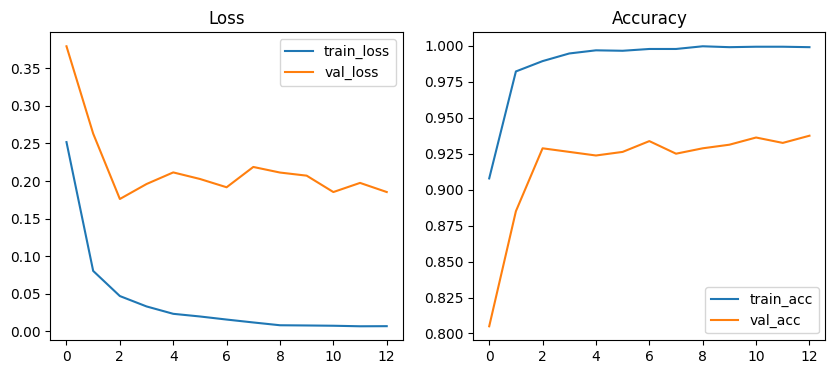

In [ ]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt  # 시각화를 위해 matplotlib 가져오기

# === 1) build_dnn_model 함수 정의 (항상 2개 블록) ===
def build_dnn_model(
    input_shape,
    units1=128,
    units2=64,
    dropout1=0.3,
    dropout2=0.3,
    learning_rate=1e-3
):
    """
    항상 은닉층 2개를 쌓는 DNN 모델.
    units1, units2: 첫 번째·두 번째 Dense 블록 유닛 수
    dropout1, dropout2: 각 블록 다음에 사용할 Dropout 비율
    learning_rate: Adam 옵티마이저 학습률
    """
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())

    # 첫 번째 Dense 블록
    model.add(layers.Dense(units1, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(dropout1))

    # 두 번째 Dense 블록
    model.add(layers.Dense(units2, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(dropout2))

    # 출력층
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === 2) objective 함수 정의 ===
def objective(trial):
    # 2-1) 튜닝할 하이퍼파라미터 샘플링
    units1 = trial.suggest_categorical("units1", [64, 96, 128, 192, 256, 384, 512])
    units2 = trial.suggest_categorical("units2", [32, 64, 128, 256])
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5, step=0.1)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # 2-2) 학습/검증용 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=41
    )

    # 2-3) 클래스 가중치 계산 (필요 시)
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {cls: w for cls, w in zip(np.unique(y_train), class_weights_array)}

    # 2-4) 모델 생성 (항상 2개 블록)
    input_shape = X_train.shape[1:]
    model = build_dnn_model(
        input_shape=input_shape,
        units1=units1,
        units2=units2,
        dropout1=dropout1,
        dropout2=dropout2,
        learning_rate=learning_rate
    )

    # 2-5) 콜백 정의
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # 2-6) 모델 학습
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    # 2-7) 마지막 에폭의 검증 정확도 반환
    val_acc = history.history["val_accuracy"][-1]
    print(f"[Trial {trial.number:>2d}] "
          f"units1={units1}, units2={units2}, "
          f"dropout1={dropout1:.1f}, dropout2={dropout2:.1f}, "
          f"lr={learning_rate:.1e}, batch_size={batch_size} → val_acc={val_acc:.4f}\n")
    return val_acc

# ============================================
# 3) Optuna 스터디 생성 및 최적화 실행
# ============================================
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print("========== 최적 하이퍼파라미터 ==========")
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

    # ============================================
    # 4) 최적 파라미터로 전체 데이터 재학습
    # ============================================
    best = study.best_params
    final_model = build_dnn_model(
        input_shape=X.shape[1:],
        units1=best["units1"],
        units2=best["units2"],
        dropout1=best["dropout1"],
        dropout2=best["dropout2"],
        learning_rate=best["learning_rate"]
    )

    callbacks_final = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # 4-1) 최종 학습 결과를 history 객체로 저장
    final_history = final_model.fit(
        X, y,
        validation_split=0.2,
        epochs=50,
        batch_size=best["batch_size"],
        class_weight={cls: w for cls, w in zip(np.unique(y), compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        ))},
        callbacks=callbacks_final,
        verbose=1
    )

    # ============================================
    # 5) 최종 학습 과정 시각화 (plot_history 함수 사용)
    # ============================================
    def plot_history(history):
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='train_acc')
        plt.plot(history.history['val_accuracy'], label='val_acc')
        plt.title("Accuracy")
        plt.legend()

        plt.show()

    # plot_history 함수를 호출하여 학습/검증 지표 시각화
    plot_history(final_history)

    # 5-2) 모델 저장
    final_model.save("dnn_model.h5")


In [ ]:
# Optuna 튜닝 완료 후, 동일 best_value를 가진 Trial 중 최종 Best를 선택하는 후처리 코드

# 1) Optuna가 기록한 최고 검증 정확도 가져오기
best_value = study.best_value

# 2) 동일한 value를 가진 모든 Trial 리스트 생성
same_value_trials = [t for t in study.trials if t.value == best_value]

# 3) 모델 복잡도 계산 함수 (units1 * units2)
def model_complexity(trial):
    return trial.params.get("units1", float("inf")) * trial.params.get("units2", float("inf"))

# 4) 실행 시간 계산 함수
def trial_duration(trial):
    if trial.datetime_start and trial.datetime_complete:
        return (trial.datetime_complete - trial.datetime_start).total_seconds()
    return float("inf")

# 5) Tie-breaker: 1차 기준=모델 복잡도(작을수록 우선), 2차 기준=실행 시간(짧을수록 우선)
def tie_breaker_key(trial):
    return (model_complexity(trial), trial_duration(trial))

# 6) 정렬 후 최종 Best Trial 선택
sorted_trials = sorted(same_value_trials, key=tie_breaker_key)
final_best = sorted_trials[0]

# 7) 최종 Best 파라미터
best_params = final_best.params

# 예시 출력
print("========== 최종 Tie-breaker 적용 결과 ==========")
for key, value in best_params.items():
    print(f"{key}: {value}")


========== 최종 Tie-breaker 적용 결과 ==========
units1: 64
units2: 128
dropout1: 0.30000000000000004
dropout2: 0.4
learning_rate: 0.00023837704617109712
batch_size: 16


# 테스트 데이터 로딩 및 평가

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.81      1.00      0.89      1000
        Fake       1.00      0.76      0.87      1000

    accuracy                           0.88      2000
   macro avg       0.90      0.88      0.88      2000
weighted avg       0.90      0.88      0.88      2000

ROC AUC: 0.905


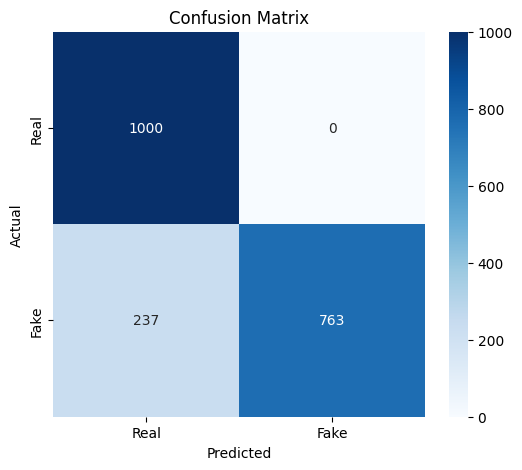

In [ ]:
# -------------------------------------------
# 6. 테스트 데이터 평가
# -------------------------------------------
from tensorflow.keras.models import load_model

model = load_model("dnn_model.h5")


y_prob = model.predict(X_test)
y_pred = (y_prob > 0.8).astype(int)

print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Spectral_Contrast 특징 활용 모델
- 오분류된 데이터에 대해서 따로 특징을 추출하여 분류를 시도함. 이를 활용하여 약 1% 성능 향상이 가능하였음.

In [ ]:
def predict_with_spectral_contrast(model,X_test, score:float = 0.32):
    # 🔹 1. DNN 예측
    y_prob = model.predict(X_test).flatten()

    # 🔹 2. 보정 대상: 확률이 낮은 샘플
    uncertain_idx = np.where(y_prob < score)[0]

    # 🔹 3. test_label.txt에서 파일 이름 가져오기
    df = pd.read_csv(test_label_path, sep='\s+', header=None, usecols=[1, 4], names=['filename', 'label'])

    # 라벨을 숫자로 변환
    df['label'] = df['label'].map({'Real': 0, 'Fake': 1})

    # 리스트와 배열로 추출
    test_filenames = df['filename'].tolist()
    y_test = df['label'].values.astype(int)

    # # 확인
    # print("✅ 파일 예시:", test_filenames[:5])
    # print("✅ 라벨 분포:", pd.Series(y_test).value_counts().to_dict())


    # 🔹 4. Spectral contrast 기반 보정
    for idx in tqdm(uncertain_idx, desc="📌 Spectral Contrast 보정 중"):
        filename = test_filenames[idx]
        file_path = os.path.join(test_audio_path, filename)

        try:
            y, sr = librosa.load(file_path, sr=16000)
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            high_contrast = np.mean(contrast[-2:, :])  # 고주파 2대역 평균

            if (high_contrast < 21.0 or high_contrast > 27.0):
                y_prob[idx] = 1.0  # Fake로 강제 보정
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")
    return y_prob

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


📌 Spectral Contrast 보정 중: 100%|████████████████████████████████████████████████| 1186/1186 [00:12<00:00, 96.40it/s]



✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.86      1.00      0.92      1000
        Fake       1.00      0.83      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.93      0.91      0.91      2000
weighted avg       0.93      0.91      0.91      2000

ROC AUC: 0.916


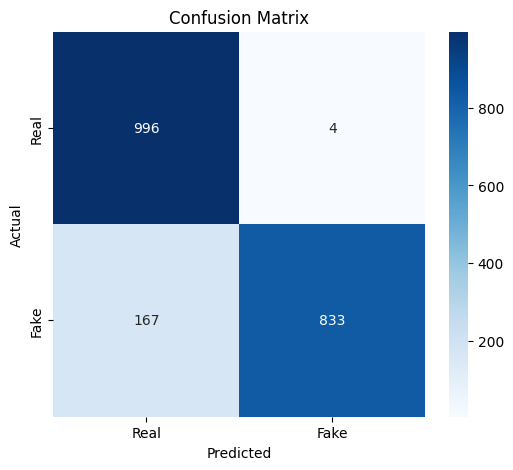

In [ ]:
# 🔹 5. 최종 이진 판정 (확률 기준은 0.5 유지)
y_prob = predict_with_spectral_contrast(model,X_test, score=0.5)
y_pred = (y_prob >= 0.5).astype(int)
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Spectral contrast 최적화 기준 자동화 선별 함수 (실험 코드)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import os

# 1) 실제 오디오 파일들이 들어 있는 디렉토리 경로
test_audio_path = "test"   # 예시: 테스트 오디오가 들어 있는 폴더명

# 2) 해당 폴더에 있는 모든 .wav 파일 이름을 리스트로 가져오기
test_filenames = sorted([
    f for f in os.listdir(test_audio_path)
    if f.lower().endswith('.wav')
])



def run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                   prob_thresholds=[0.3, 0.4, 0.5, 0.6],
                   contrast_bounds=[(22.0, 26.0), (23.0, 26.5), (22.5, 27.0)]):

    results = []

    for prob_thresh in prob_thresholds:
        for contrast_low, contrast_high in contrast_bounds:
                    # 1. DNN 확률 예측
          y_prob = model.predict(X_test).flatten()

          # 2. 보정 대상 (확률 기준 이하)
          uncertain_idx = np.where(y_prob < prob_thresh)[0]

          # 3. Spectral Contrast 보정
          for idx in tqdm(uncertain_idx, desc=f"🔍 p<{prob_thresh}, c<{contrast_low} or >{contrast_high}"):
              file_path = os.path.join(test_audio_path, test_filenames[idx])
              try:
                  y, sr = librosa.load(file_path, sr=16000)
                  contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                  high_contrast = np.mean(contrast[-2:, :])

                  # Fake로 보정 조건
                  if high_contrast < contrast_low or high_contrast > contrast_high:
                      y_prob[idx] = 1.0  # Fake로 강제 보정
              except Exception as e:
                  print(f"⚠️ Error: {file_path} - {e}")
          for a in prob_thresholds:
            # 4. 이진 결과
            y_pred = (y_prob >= a).astype(int)

            # 5. 지표 계산
            acc = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

            # 6. 기록
            results.append({
                'a' : a,
                'prob_thresh': prob_thresh,
                'contrast_low': contrast_low,
                'contrast_high': contrast_high,
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

    return pd.DataFrame(results)

In [ ]:
# 실험 설정 값
prob_thresholds = [0.32]
contrast_bounds = [(21,27),(20.5, 27.5)]

# 실행
result_df = run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                           prob_thresholds, contrast_bounds)

# 결과 출력 (F1-score 기준 정렬)
result_df_sorted = result_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

from IPython.display import display
display(result_df_sorted)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


🔍 p<0.32, c<21 or >27: 100%|█████████████████████████████████████████████████████| 1169/1169 [00:10<00:00, 108.23it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


🔍 p<0.32, c<20.5 or >27.5: 100%|█████████████████████████████████████████████████| 1169/1169 [00:10<00:00, 111.24it/s]


,a,prob_thresh,contrast_low,contrast_high,accuracy,precision,recall,f1
0,0.32,0.32,20.5,27.5,0.909,0.919745,0.909,0.908414
1,0.32,0.32,21.0,27.0,0.903,0.911534,0.903,0.902495


# 예측 결과 파일 작성

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from IPython.display import display

# ─────────── 1. 예측 결과(team_test_result.txt) 읽기 ───────────
# team_test_result.txt 형식: "<filename> <label>" (label은 "Fake" 또는 "Real" 문자열)
pred_df = pd.read_csv(
    "team_test_result.txt",
    sep="\s+",            # 공백(스페이스나 탭)으로 구분
    header=None,          # 컬럼명이 없음을 알려 줌
    names=["filename", "pred_str"]  # 파일명과 예측 라벨 문자열을 읽음
)

# ─────────── 2. 실제 레이블(label/test_label.txt) 읽기 ───────────
# test_label.txt 형식: "<index> <filename> <start> <end> <label>" 와 같은 5개 항목이 있고,
# 여기서 두 번째 항목(parts[1])이 파일명이므로 get_test_filenames 함수에서 filenames를 추출했습니다.
# 그러나 평가할 때는 test_label.txt 내부에서 filename과 “실제 라벨(Fake/Real)” 두 개만 필요하므로,
# 미리 LabelEncoder를 이용해 0/1로 인코딩해 둔 부분이 있습니다. 이번에는 그냥 “label_str”을 읽어옵니다.

# test_label.txt에 “index filename start end label” 형태로 되어 있다면:
true_df = pd.read_csv(
    "test_label.txt",
    sep="\s+",
    header=None,
    names=["idx", "filename", "start", "end", "true_str"]
)

# ─────────── 3. 문자열 라벨(“Fake”/“Real”)을 0/1 숫자로 바꾸기 ───────────
# LabelEncoder로 “Fake”→0, “Real”→1 매핑한 객체를 사용합니다.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["Fake", "Real"])  # 0=Fake, 1=Real

# 실제 라벨(문자열) → 숫자 벡터
true_df["true"] = le.transform(true_df["true_str"])

# 예측 라벨(문자열) → 숫자 벡터
pred_df["pred"] = le.transform(pred_df["pred_str"])

# ─────────── 4. 파일명 기준으로 병합(merge) ───────────
#    두 DataFrame 모두 “filename” 컬럼이므로 inner join으로 합칩니다.
merged = pd.merge(
    true_df[["filename", "true"]],
    pred_df[["filename", "pred"]],
    on="filename",
    how="inner"
)

if len(merged) != len(true_df):
    print("⚠️ 경고: 병합된 행(row) 수가 예상과 다릅니다.")
    print(f"   실제 레이블 개수: {len(true_df)}, 병합된 개수: {len(merged)}")
else:
    print(f"✅ 병합된 행 개수: {len(merged)} (테스트 파일 전체 개수와 동일)")

# ─────────── 5. 평가 지표(Accuracy, Precision, Recall, F1-score) 계산 ───────────
y_true = merged["true"].values
y_pred = merged["pred"].values

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)

print("\n▶ 평가 지표")
print(f"   Accuracy : {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall   : {rec:.4f}")
print(f"   F1-score : {f1:.4f}")

# ─────────── 6. 혼동 행렬(Confusion Matrix) 출력 ───────────
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"실제 {lab}" for lab in le.classes_],       # ["실제 Fake", "실제 Real"]
    columns=[f"예측 {lab}" for lab in le.classes_]      # ["예측 Fake", "예측 Real"]
)
print("\n▶ 혼동 행렬 (Confusion Matrix)")
display(cm_df)

# ─────────── 7. (옵션) 잘못 예측한 파일명 리스트 몇 개 출력 ───────────
mask_fp = (merged["true"] == 0) & (merged["pred"] == 1)  # False Positive (원래는 Fake인데 Real로 예측)
mask_fn = (merged["true"] == 1) & (merged["pred"] == 0)  # False Negative (원래는 Real인데 Fake로 예측)

print(f"\n▶ False Positive 개수: {mask_fp.sum()}")
print("   샘플 예시:", merged.loc[mask_fp, "filename"].tolist()[:5], "…")

print(f"▶ False Negative 개수: {mask_fn.sum()}")
print("   샘플 예시:", merged.loc[mask_fn, "filename"].tolist()[:5], "…")


✅ 병합된 행 개수: 2000 (테스트 파일 전체 개수와 동일)

▶ 평가 지표
   Accuracy : 0.9215
   Precision: 0.8688
   Recall   : 0.9930
   F1-score : 0.9267

▶ 혼동 행렬 (Confusion Matrix)


,예측 Fake,예측 Real
실제 Fake,850,150
실제 Real,7,993



▶ False Positive 개수: 150
   샘플 예시: ['KDF_E_0420.wav', 'KDF_E_0293.wav', 'KDF_E_1380.wav', 'KDF_E_0574.wav', 'KDF_E_0473.wav'] …
▶ False Negative 개수: 7
   샘플 예시: ['KDF_E_0851.wav', 'KDF_E_0269.wav', 'KDF_E_1863.wav', 'KDF_E_0410.wav', 'KDF_E_0199.wav'] …
